In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing as pre
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import pickle as pkl
import seaborn as sns
import operator

In [3]:
train = pd.read_csv('train.csv')
train = train.drop('Id', axis = 1)

In [4]:
x = train[[i for i in train.columns if i != 'SalePrice']] # split out the target variable
y = train[['SalePrice']]

In [5]:
# 20% of data held separate for validation
train_x, test_x, train_y, test_y = train_test_split(x, y, train_size = 0.8, test_size = 0.2, random_state = 42)

In [6]:
# train_x.select_dtypes(object).nunique() # 3 categorical columns have >20 unique values. This will create a lot of features,
                                        # but they look like they'll have a lot of predictive power

In [7]:
train_x = pd.get_dummies(train_x)

In [8]:
fillnas = SimpleImputer()

scaled_vals = fillnas.fit_transform(train_x) # teach imputer how to handle NaNs in each column, and fill in train_x's NaNs
train_x = pd.DataFrame(scaled_vals, index = train_x.index, columns = train_x.columns)

pkl.dump(fillnas, open('fillnas.pkl', mode = 'wb'))

In [9]:
scaler = pre.StandardScaler().fit(train_x) # teach the scaler how to standardise each column
train_x = pd.DataFrame(scaler.transform(train_x), index = train_x.index, columns = train_x.columns)

pkl.dump(scaler,open('scaler.pkl', mode = 'wb')) # save the scaler so we can use the same one each time we predict

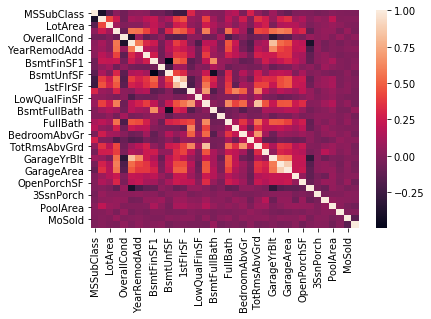

In [10]:
### CORRELATION MATRIX
corr = train_x.corr()
sns.heatmap(x.corr()); # this is hard to interpret, because there are so many features (286)

In [11]:
# Because there are so many features, we'll use a 'random forest' to select the features with greatest importance
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(train_x, train_y)

C:\Users\Josep\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [12]:
feature_importances = list(zip(train_x.columns, clf.feature_importances_))
sorted_importances = sorted(feature_importances, key = operator.itemgetter(1), reverse = True)

# for feature in sorted_importances:
#     print(feature)

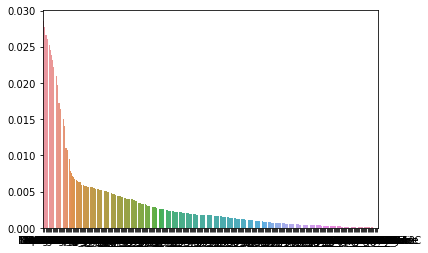

In [13]:
sns.barplot(x = [i[0] for i in sorted_importances], y = [i[1] for i in sorted_importances]);

# considering that these importances add up to 100, and there isn't an importance higher than .03, the importances are 
# reasonable well spread

In [14]:
df_importances = pd.DataFrame(data = sorted_importances, columns = ['feature', 'importance'])

In [15]:
df_importances[df_importances['importance'] <= 0.001].count()
# by removing features with an importance score equal to or lower than .001 we reduce our number of features by over a third

feature       104
importance    104
dtype: int64

In [16]:
restricted_df = df_importances[df_importances['importance'] > 0.001]
restricted_features = list(restricted_df['feature'])

In [19]:
train_x_restricted = train_x.filter(restricted_features, axis = 1)

In [29]:
# now we have the features we're actually interested in, we run PCA to eliminate multicollinearity.
